In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%cd /content/drive/MyDrive/Research/Cifar

/content/drive/MyDrive/Research/Cifar


In [30]:
#@title (Run) Part 1: Define required functions for Data processing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
import os
import argparse
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def balance_val_split(dataset, train_size=12500):

    try:
        targets = np.array(dataset.targets)
    except:
        targets = []  # create an empty list to store the targets
        for data in dataset.datasets:
            targets += data.targets  # concatenate the targets from each dataset into the list
        targets = np.array(targets)
    #targets = np.array(dataset.datasets.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        train_size=train_size,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    # Get the data from the subset dataset
    subset_data = [train_dataset[idx][0] for idx in range(len(train_dataset))]
    subset_labels = [train_dataset[idx][1] for idx in range(len(train_dataset))]
    # Create a dataset from the list of data and targets
    train_dataset = MyDataset(subset_data, subset_labels)
    
    
    val_dataset = Subset(dataset, indices=val_indices)
    # Get the data from the subset dataset
    subset_data = [val_dataset[idx][0] for idx in range(len(val_dataset))]
    subset_labels = [val_dataset[idx][1] for idx in range(len(val_dataset))]
    # Create a dataset from the list of data and targets
    val_dataset = MyDataset(subset_data, subset_labels)

    return train_dataset, val_dataset


def count_label_frequency(target_train_dataset):
	from collections import Counter
	target_labels = []  # create an empty list to store the labels

	for i in range(len(target_train_dataset)):
			_, label = target_train_dataset[i]  # extract the label for the i-th example in the subset
			target_labels.append(label)  # append the label to the 'subset_labels' list


	return Counter(target_labels)
 


def custom_transform(image: Tensor) -> Tensor:
    import random
    # randomly flip horizontally or vertically with 25% chance
    if random.random() < 0.25:
        image = RandomHorizontalFlip(p=1)(image)
    elif random.random() < 0.5:
        image = RandomVerticalFlip(p=1)(image)
    
    # randomly shift the image by 2 pixels to the left or right with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2], image.shape[-1] - 2), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2], image.shape[-1] + 2), pad_if_needed=False)(image)
        
    # randomly shift the image by 2 pixels to the top or bottom with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2] - 2, image.shape[-1]), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2] + 2, image.shape[-1]), pad_if_needed=False)(image)

    return image

In [31]:
#@title (Run) Part 2: Define required functions for Data Training

# Training
def train(trainloader, epoch, batch_size=128, logfile = "train.summary"):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
          print(inputs.shape)
          continue
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 30 == 0:
                print(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(trainloader), 'Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)\n'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()

def test(testloader, epoch, batch_size=128, logfile = "train.summary", save_modelpath = './DLA'):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0



    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 30 == 0:
                print(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(testloader), 'Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)\n'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_modelpath):
            os.mkdir(save_modelpath)
        torch.save(state, save_modelpath+'/ckpt.pth')
        best_acc = acc

def draw_training_summary(filepath = 'target_train_DCA-BiLSTM.summary'):
    import matplotlib.pyplot as plt
    import numpy as np

    with open(filepath, 'r') as f:
        results_summary = f.read()

    train_epoch = []
    train_loss = []
    train_acc = []
    test_epoch = []
    test_loss=[]
    test_acc=[]
    for line in results_summary.split("\n"):
        try:
            r_epoch = line.split('|')[0].strip().split(' ')[1]
            r_loss = line.split('|')[1].strip().split(' ')[2].replace('%','')
            r_acc = line.split('|')[2].strip().split(' ')[2].replace('%','')
            if 'Train' in line:
                train_epoch.append(int(r_epoch))
                train_loss.append(float(r_loss))
                train_acc.append(float(r_acc))
            if 'Test' in line:
                test_epoch.append(int(r_epoch))
                test_loss.append(float(r_loss))
                test_acc.append(float(r_acc))
        except:
            print(line)

    # Create a new figure and plot the data
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    plt.axhline(y=np.max(test_acc), color='r', linestyle='--')
    # Add text for the horizontal line
    plt.text(test_epoch[-10], np.max(test_acc)*1.05, np.max(test_acc), color='r', fontsize=10)
    # Customize the plot
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')

    # Customize the plot
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



    # Display the plot
    plt.show()

In [32]:
#@title (Run) Part 3: Prepare Cifar10 dataset for target and shadow model
import pickle
from torch.utils.data import DataLoader
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def create_cifar_dataset_torch(load_data = False, batch_size=128, target_train_size = 15000, target_test_size= 15000, shadow_train_size = 15000, shadow_test_size= 15000):

  # Data
  print('==> Preparing data..')
  if not load_data:

      transform = transforms.Compose([
            transforms.ToTensor()
        ])

      cifar_trainset = torchvision.datasets.CIFAR10(
          root='./data', train=True, download=True, transform=transform)


      cifar_testset = torchvision.datasets.CIFAR10(
          root='./data', train=False, download=True, transform=transform)

      cifar_dataset = torch.utils.data.ConcatDataset([cifar_trainset, cifar_testset])


      #target_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(cifar_dataset) - target_train_size
      target_train_dataset, remain_dataset = torch.utils.data.random_split(cifar_dataset, [target_train_size, remain_size])

      #target_test_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - target_test_size
      target_test_dataset, remain_dataset = torch.utils.data.random_split(remain_dataset, [target_test_size, remain_size])

      #target_test_dataset, remain_dataset = balance_val_split(remain_dataset, train_size=target_test_size)


      #shadow_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - shadow_train_size
      shadow_train_dataset, shadow_test_dataset = torch.utils.data.random_split(remain_dataset, [shadow_train_size, remain_size])
      #shadow_train_dataset, shadow_test_dataset = balance_val_split(remain_dataset, train_size=shadow_train_size)

      print("Setting target_train_dataset size to ",len(target_train_dataset), count_label_frequency(target_train_dataset))
      print("Setting target_test_dataset size to ",len(target_test_dataset), count_label_frequency(target_test_dataset))
      print("Setting shadow_train_dataset size to ",len(shadow_train_dataset), count_label_frequency(shadow_train_dataset))
      print("Setting shadow_test_dataset size to ",len(shadow_test_dataset), count_label_frequency(shadow_test_dataset))
      #print("Setting testset size to ",len(testset))



      '''
      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
      '''



      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          custom_transform,
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      # apply the data augmentation transformations to the subset
      target_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      target_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      # apply the data augmentation transformations to the subset
      shadow_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      shadow_trainloader = DataLoader(shadow_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      shadow_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      shadow_testloader = DataLoader(shadow_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

      pickle.dump(target_trainloader, open('target_trainloader_resnet.p', 'wb'))
      pickle.dump(target_testloader, open('target_testloader_resnet.p', 'wb'))
      pickle.dump(shadow_trainloader, open('shadow_trainloader_resnet.p', 'wb'))
      pickle.dump(shadow_testloader, open('shadow_test_dataset_resnet.p', 'wb'))
    
  data_file = open('target_trainloader_resnet.p', 'rb')
  target_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('target_testloader_resnet.p', 'rb')
  target_testloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_trainloader_resnet.p', 'rb')
  shadow_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_test_dataset_resnet.p', 'rb')
  shadow_testloader = pickle.load(data_file)
  data_file.close()


  return target_trainloader, target_testloader, shadow_trainloader, shadow_testloader


In [33]:
#@title (Run) Part 4.4: Define required functions for ResNet

'''
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, enable_RNN='LSTM'):
        super(ResNet, self).__init__()
        
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        
        
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(512*block.expansion, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(512*block.expansion, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(512*block.expansion, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")

        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        
        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18-BiLSTM'  #@param {type:"string"}
save_model_folder = './Target-ResNet18-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18-BiLSTM


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==> Training model from scratch..
Total trained parameters:  53185610


In [27]:
#@title (Run) Part 5.1.2: Setup Target and Shadow datasets for ReNet Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_trainloader, shadow_testloader = create_cifar_dataset_torch(load_data=True,batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_test_size, shadow_train_size = shadow_train_size, shadow_test_size= shadow_test_size)

==> Preparing dataset..
==> Preparing data..


In [ ]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_Resnet18-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.305 | Train Acc: 9.375% (6/64)
30 234 Train Loss: 2.279 | Train Acc: 12.903% (256/1984)
60 234 Train Loss: 2.150 | Train Acc: 17.725% (692/3904)
90 234 Train Loss: 2.043 | Train Acc: 21.034% (1225/5824)
120 234 Train Loss: 1.973 | Train Acc: 24.006% (1859/7744)
150 234 Train Loss: 1.914 | Train Acc: 26.490% (2560/9664)
180 234 Train Loss: 1.860 | Train Acc: 28.574% (3310/11584)
210 234 Train Loss: 1.822 | Train Acc: 30.110% (4066/13504)
234 Epoch: 0 | Train Loss: 1.790 | Train Acc: 31.490% (4716/14976)
0 234 Test Loss: 1.692 | Test Acc: 34.375% (22/64)
30 234 Test Loss: 1.824 | Test Acc: 32.409% (643/1984)
60 234 Test Loss: 1.806 | Test Acc: 33.478% (1307/3904)
90 234 Test Loss: 1.794 | Test Acc: 34.083% (1985/5824)
120 234 Test Loss: 1.807 | Test Acc: 33.600% (2602/7744)
150 234 Test Loss: 1.798 | Test Acc: 33.723% (3259/9664)
180 234 Test Loss: 1.796 | Test Acc: 33.676% (3901/11584)
210 234 Test Loss: 1.802 | Test Acc: 33.509% (4525/13504)
234 Epoch: 0 |

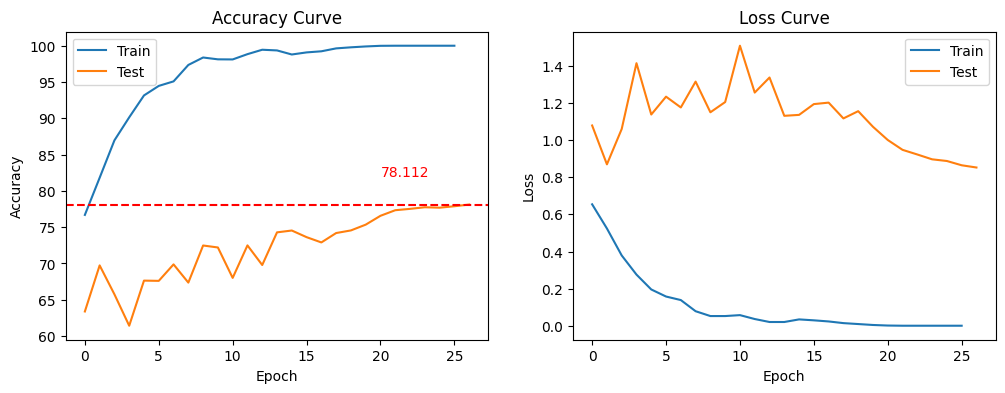

In [ ]:
draw_training_summary(filepath = 'target_train_Resnet18-BiLSTM.summary')

In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18-BiLSTM'  #@param {type:"string"}
save_model_folder = './Shadow-ResNet18-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18-BiLSTM
==> Training model from scratch..
Total trained parameters:  53185610


In [ ]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_Resnet18-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.299 | Train Acc: 12.500% (8/64)
30 234 Train Loss: 2.278 | Train Acc: 14.214% (282/1984)
60 234 Train Loss: 2.159 | Train Acc: 18.724% (731/3904)
90 234 Train Loss: 2.053 | Train Acc: 21.549% (1255/5824)
120 234 Train Loss: 1.976 | Train Acc: 24.070% (1864/7744)
150 234 Train Loss: 1.918 | Train Acc: 26.397% (2551/9664)
180 234 Train Loss: 1.865 | Train Acc: 28.125% (3258/11584)
210 234 Train Loss: 1.816 | Train Acc: 30.087% (4063/13504)
234 Epoch: 0 | Train Loss: 1.783 | Train Acc: 31.377% (4699/14976)
0 234 Test Loss: 1.560 | Test Acc: 34.375% (22/64)
30 234 Test Loss: 1.501 | Test Acc: 43.498% (863/1984)
60 234 Test Loss: 1.493 | Test Acc: 43.648% (1704/3904)
90 234 Test Loss: 1.494 | Test Acc: 43.544% (2536/5824)
120 234 Test Loss: 1.498 | Test Acc: 43.259% (3350/7744)
150 234 Test Loss: 1.497 | Test Acc: 43.129% (4168/9664)
180 234 Test Loss: 1.493 | Test Acc: 43.551% (5045/11584)
210 234 Test Loss: 1.492 | Test Acc: 43.706% (5902/13504)
234 Epoch: 0 

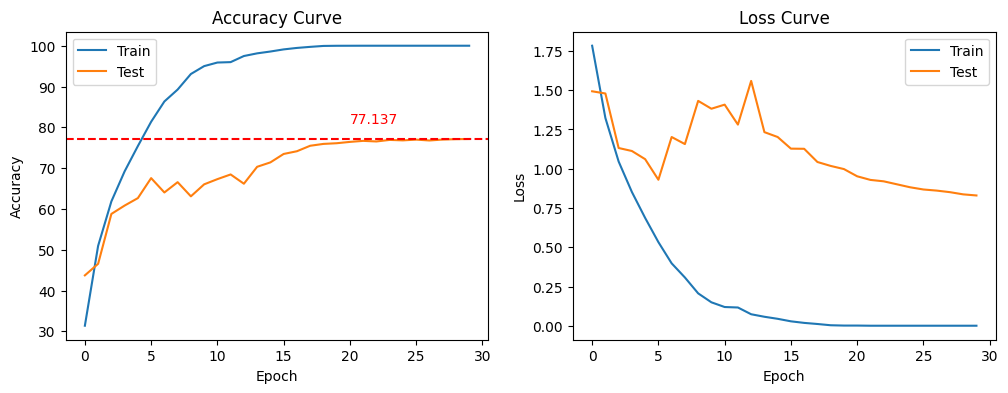

In [ ]:
draw_training_summary(filepath = 'shadow_train_Resnet18-BiLSTM.summary')

In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18-LSTM'  #@param {type:"string"}
save_model_folder = './Target-ResNet18-LSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18-LSTM
==> Training model from scratch..
Total trained parameters:  17478730


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_Resnet18-LSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.316 | Train Acc: 6.250% (4/64)
30 234 Train Loss: 2.253 | Train Acc: 14.567% (289/1984)
60 234 Train Loss: 2.158 | Train Acc: 17.802% (695/3904)
90 234 Train Loss: 2.083 | Train Acc: 20.673% (1204/5824)
120 234 Train Loss: 2.020 | Train Acc: 22.934% (1776/7744)
150 234 Train Loss: 1.966 | Train Acc: 24.938% (2410/9664)
180 234 Train Loss: 1.922 | Train Acc: 26.519% (3072/11584)
210 234 Train Loss: 1.878 | Train Acc: 28.369% (3831/13504)
234 Epoch: 0 | Train Loss: 1.846 | Train Acc: 29.667% (4443/14976)
0 234 Test Loss: 1.599 | Test Acc: 46.875% (30/64)
30 234 Test Loss: 1.544 | Test Acc: 41.230% (818/1984)
60 234 Test Loss: 1.548 | Test Acc: 41.726% (1629/3904)
90 234 Test Loss: 1.555 | Test Acc: 41.089% (2393/5824)
120 234 Test Loss: 1.553 | Test Acc: 41.090% (3182/7744)
150 234 Test Loss: 1.553 | Test Acc: 41.049% (3967/9664)
180 234 Test Loss: 1.552 | Test Acc: 41.143% (4766/11584)
210 234 Test Loss: 1.552 | Test Acc: 41.217% (5566/13504)
234 Epoch: 0 |

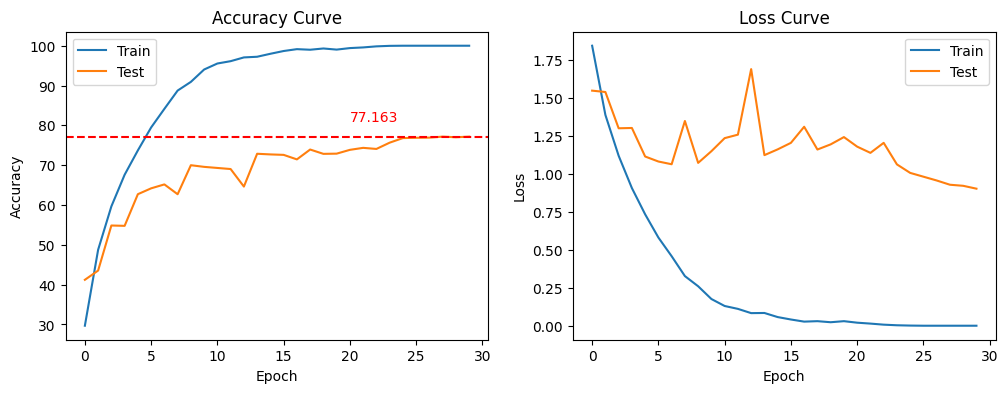

In [ ]:
draw_training_summary(filepath = 'target_train_Resnet18-LSTM.summary')

In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18-LSTM'  #@param {type:"string"}
save_model_folder = './Shadow-ResNet18-LSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18-LSTM
==> Training model from scratch..
Total trained parameters:  17478730


In [ ]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_Resnet18-LSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.307 | Train Acc: 14.062% (9/64)
30 234 Train Loss: 2.255 | Train Acc: 16.079% (319/1984)
60 234 Train Loss: 2.157 | Train Acc: 18.801% (734/3904)
90 234 Train Loss: 2.072 | Train Acc: 21.240% (1237/5824)
120 234 Train Loss: 2.009 | Train Acc: 23.399% (1812/7744)
150 234 Train Loss: 1.955 | Train Acc: 25.362% (2451/9664)
180 234 Train Loss: 1.913 | Train Acc: 26.977% (3125/11584)
210 234 Train Loss: 1.872 | Train Acc: 28.592% (3861/13504)
234 Epoch: 0 | Train Loss: 1.843 | Train Acc: 29.754% (4456/14976)
0 234 Test Loss: 1.865 | Test Acc: 28.125% (18/64)
30 234 Test Loss: 1.870 | Test Acc: 29.788% (591/1984)
60 234 Test Loss: 1.849 | Test Acc: 30.277% (1182/3904)
90 234 Test Loss: 1.836 | Test Acc: 31.027% (1807/5824)
120 234 Test Loss: 1.842 | Test Acc: 31.134% (2411/7744)
150 234 Test Loss: 1.835 | Test Acc: 31.178% (3013/9664)
180 234 Test Loss: 1.832 | Test Acc: 31.276% (3623/11584)
210 234 Test Loss: 1.838 | Test Acc: 31.183% (4211/13504)
234 Epoch: 0 

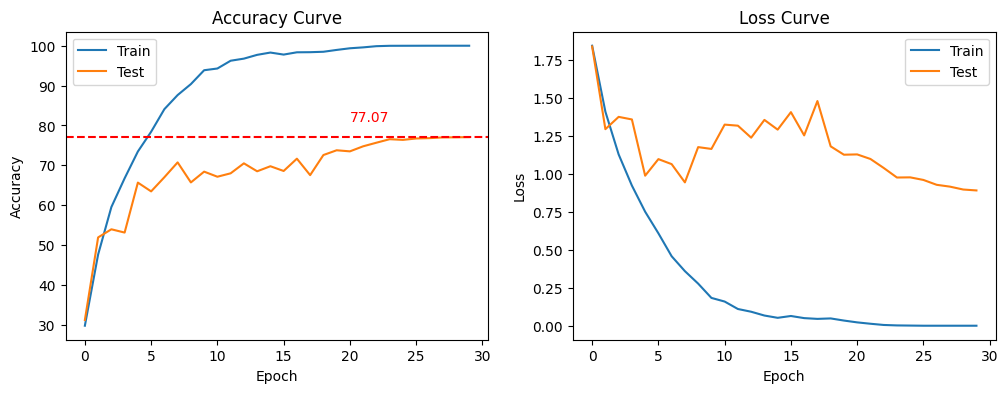

In [ ]:
draw_training_summary(filepath = 'shadow_train_Resnet18-LSTM.summary')

In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18'  #@param {type:"string"}
save_model_folder = './Target-ResNet18_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18
==> Training model from scratch..
Total trained parameters:  11173962


In [ ]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_Resnet18.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.308 | Train Acc: 14.062% (9/64)
30 234 Train Loss: 2.110 | Train Acc: 25.101% (498/1984)
60 234 Train Loss: 1.998 | Train Acc: 27.766% (1084/3904)
90 234 Train Loss: 1.926 | Train Acc: 30.598% (1782/5824)
120 234 Train Loss: 1.844 | Train Acc: 33.174% (2569/7744)
150 234 Train Loss: 1.779 | Train Acc: 35.079% (3390/9664)
180 234 Train Loss: 1.739 | Train Acc: 36.861% (4270/11584)
210 234 Train Loss: 1.704 | Train Acc: 38.092% (5144/13504)
234 Epoch: 0 | Train Loss: 1.680 | Train Acc: 39.016% (5843/14976)
0 234 Test Loss: 1.727 | Test Acc: 37.500% (24/64)
30 234 Test Loss: 1.727 | Test Acc: 43.397% (861/1984)
60 234 Test Loss: 1.715 | Test Acc: 42.649% (1665/3904)
90 234 Test Loss: 1.731 | Test Acc: 42.222% (2459/5824)
120 234 Test Loss: 1.725 | Test Acc: 42.213% (3269/7744)
150 234 Test Loss: 1.730 | Test Acc: 42.281% (4086/9664)
180 234 Test Loss: 1.727 | Test Acc: 42.308% (4901/11584)
210 234 Test Loss: 1.727 | Test Acc: 42.417% (5728/13504)
234 Epoch: 0

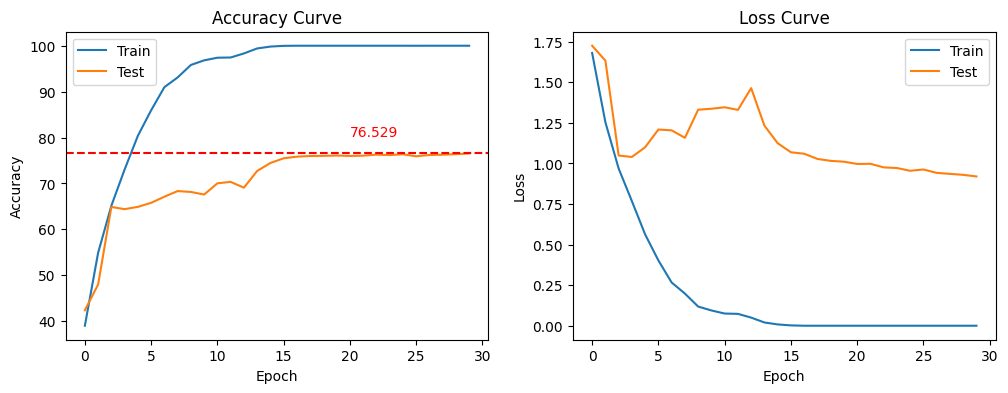

In [ ]:
draw_training_summary(filepath = 'target_train_Resnet18.summary')

In [35]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18'  #@param {type:"string"}
save_model_folder = './Shadow-ResNet18_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18
==> Training model from scratch..
Total trained parameters:  11173962


In [36]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_Resnet18.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.455 | Train Acc: 10.938% (7/64)
30 234 Train Loss: 2.080 | Train Acc: 21.925% (435/1984)
60 234 Train Loss: 1.990 | Train Acc: 27.715% (1082/3904)
90 234 Train Loss: 1.911 | Train Acc: 30.872% (1798/5824)
120 234 Train Loss: 1.858 | Train Acc: 32.709% (2533/7744)
150 234 Train Loss: 1.800 | Train Acc: 34.737% (3357/9664)
180 234 Train Loss: 1.746 | Train Acc: 36.723% (4254/11584)
210 234 Train Loss: 1.705 | Train Acc: 38.196% (5158/13504)
234 Epoch: 0 | Train Loss: 1.678 | Train Acc: 39.103% (5856/14976)
0 234 Test Loss: 1.955 | Test Acc: 39.062% (25/64)
30 234 Test Loss: 1.661 | Test Acc: 40.575% (805/1984)
60 234 Test Loss: 1.631 | Test Acc: 41.317% (1613/3904)
90 234 Test Loss: 1.625 | Test Acc: 41.449% (2414/5824)
120 234 Test Loss: 1.617 | Test Acc: 41.916% (3246/7744)
150 234 Test Loss: 1.622 | Test Acc: 41.639% (4024/9664)
180 234 Test Loss: 1.609 | Test Acc: 41.963% (4861/11584)
210 234 Test Loss: 1.605 | Test Acc: 42.225% (5702/13504)
234 Epoch: 0

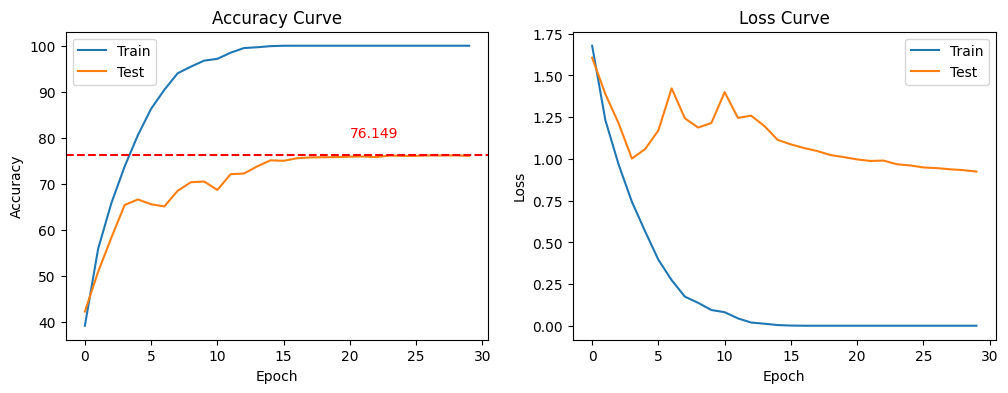

In [37]:
draw_training_summary(filepath = 'shadow_train_Resnet18.summary')